## Imports

In [91]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geopy.distance
import matplotlib.pyplot as plt
from shapely.geometry import Point
import shapely

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold


from scipy import stats
from sklearn import metrics
import folium

import math

from descartes import PolygonPatch
import altair as alt

from pprint import pprint

# for the notebook only (not for JupyterLab) run this command once per session
alt.renderers.enable('notebook')

import warnings
warnings.filterwarnings('ignore')

## Defining Paths

In [92]:
### Consts
datapath = '../rawdata/sensors/'
metadata_file = datapath + 'nodes.txt'

## Loading external datasets

In [93]:
## loading 311
noiseComplaints = pd.read_pickle('../data/311/311.pkl')

## loading taxi
taxi = pd.read_pickle('../data/taxi/taxi.pkl')
## loading taxi regions
taxi_regions = gpd.read_file('zip://../assets/taxi_zones.zip')
taxi_regions = taxi_regions.to_crs({'init':'epsg:3857'})

## loading wind speed
windSpeed = pd.read_pickle('../data/weather/wind.pkl')
windSpeed = windSpeed.resample('H').agg({'Spd[Wind]': 'mean'})

## loading precipitation
precipitation = pd.read_pickle('../data/weather/precipitation.pkl')
precipitation = precipitation.resample('H').agg({'Amt[PrecipHourly1]': 'mean'})

## Defining intersection between datasets

In [94]:
noiseComplaints_start, noiseComplaints_end = noiseComplaints.index[0], noiseComplaints.index[-1]
taxi_start, taxi_end = taxi.index[0], taxi.index[-1]
windSpeed_start, windSpeed_end = windSpeed.index[0], windSpeed.index[-1]
precipitation_start, precipitation_end = precipitation.index[0], precipitation.index[-1]

## Calculating the largest intersection
intersection_start = max(noiseComplaints_start, taxi_start, windSpeed_start, precipitation_start)
intersection_end = min(noiseComplaints_end, taxi_end, windSpeed_end, precipitation_end)

print('311 Range: ', noiseComplaints_start, '----', noiseComplaints_end)
print('Taxi Range: ', taxi_start, '----', taxi_end)
print('Wind Speed Range: ', windSpeed_start,'----', windSpeed_end)
print('Rain Precipitation Range: ', precipitation_start,'----', precipitation_end)
print('Largest Intersection: ', intersection_start,'----', intersection_end)

311 Range:  2010-01-01 00:03:46 ---- 2019-01-28 02:11:59
Taxi Range:  2017-01-01 00:00:00 ---- 2018-07-01 23:46:41
Wind Speed Range:  2010-01-01 01:00:00 ---- 2018-04-02 00:00:00
Rain Precipitation Range:  2010-01-01 01:00:00 ---- 2018-04-02 00:00:00
Largest Intersection:  2017-01-01 00:00:00 ---- 2018-04-02 00:00:00


## Filtering sensor in manhattan

In [28]:
sensors_geodf = gpd.GeoDataFrame(crs={'init': 'epsg:4326'})

f = open(metadata_file)
for line in f:
    s, lat, lon = line.split(' ')
    
    lat = float(lat)
    lon = float(lon)
    
    ## adding sensor to geodataframe
    sensor_point = shapely.geometry.Point(lon, lat)
    sensors_geodf = sensors_geodf.append({'sensorID': s, 'geometry':sensor_point}, ignore_index=True)

# ## closing file
f.close()
    
sensors_geodf = sensors_geodf.to_crs({'init':'epsg:3857'})

# ## join taxi regions with sensors
manhattan_regions = taxi_regions[taxi_regions['borough'] == 'Manhattan']
manhattan_sensors = gpd.tools.sjoin(sensors_geodf, manhattan_regions, how='inner', op="within")

In [124]:
distributions = {}

selected_sensors = [
    'sonycnode-b827eb0d8af7.sonyc',
    'sonycnode-b827eb0fedda.sonyc',
    'sonycnode-b827eb132382.sonyc',
    'sonycnode-b827eb2a1bce.sonyc',
    'sonycnode-b827eb3e842e.sonyc',
    'sonycnode-b827eb44506f.sonyc',
    'sonycnode-b827eb815321.sonyc',
    'sonycnode-b827eb8e32ad.sonyc',
    'sonycnode-b827ebb40450.sonyc',
    'sonycnode-b827ebc6dcc6.sonyc']

f = open(metadata_file)
for line in f:
    
    # reading sensor metadata
    sensorID, lat, lon = line.split(' ')
    lat = float(lat)
    lon = float(lon)
    
    if sensorID in selected_sensors:
        
        current_location = manhattan_sensors[manhattan_sensors['sensorID'] == sensorID]['LocationID'].values[0]
        
        # loading sensor data
        sensorData = pd.read_pickle(datapath +sensorID+ '.pkl')
        sensorData.sort_index(ascending=True, inplace=True)
        
        # calculating the intersection with the external datasets
        sensorData_start, sensorData_end = sensorData.index[0], sensorData.index[-1]
        dataframe_start, dataframe_end = max(sensorData_start, intersection_start), min(sensorData_end, intersection_end)      
        
        if(dataframe_start > dataframe_end):
            print(sensorID, ': ', 'START >> END')
            continue
            
        # creating empty timeseries
        df_timeseries = pd.DataFrame()
        df_timeseries['datetime'] = pd.date_range(dataframe_start, dataframe_end, freq="1h")
        df_timeseries.set_index(['datetime'], inplace = True)
        
        # calculating the average over one hour of SPL
        sensorData['dbas'] = sensorData['sum'] / sensorData['count']
        
        # adding sensor data to the empty dataframe
        df_timeseries['dbas'] = sensorData['dbas'][dataframe_start:dataframe_end]
                
        
        
        
        
        

-----------------------------------
SensorID:  sonycnode-b827eb0d8af7.sonyc
(2185, 1)
dbas    1
dtype: int64
-----------------------------------
-----------------------------------
SensorID:  sonycnode-b827eb0fedda.sonyc
(2185, 1)
dbas    1
dtype: int64
-----------------------------------
-----------------------------------
SensorID:  sonycnode-b827eb132382.sonyc
(2185, 1)
dbas    1
dtype: int64
-----------------------------------
-----------------------------------
SensorID:  sonycnode-b827eb2a1bce.sonyc
(2185, 1)
dbas    1
dtype: int64
-----------------------------------
-----------------------------------
SensorID:  sonycnode-b827eb3e842e.sonyc
(2185, 1)
dbas    1
dtype: int64
-----------------------------------
-----------------------------------
SensorID:  sonycnode-b827eb44506f.sonyc
(2185, 1)
dbas    1
dtype: int64
-----------------------------------
-----------------------------------
SensorID:  sonycnode-b827eb815321.sonyc
(2185, 1)
dbas    1
dtype: int64
---------------------

In [117]:
distributions = {}

f = open(metadata_file)
for line in f:
    
    # reading sensor metadata
    sensorID, lat, lon = line.split(' ')
    lat = float(lat)
    lon = float(lon)
    
    if sensorID in manhattan_sensors['sensorID'].unique():
        
        current_location = manhattan_sensors[manhattan_sensors['sensorID'] == sensorID]['LocationID'].values[0]
     
        sensorData = pd.read_pickle(datapath + sensorID + '.pkl')
        
        sensorData['dbas'] = sensorData['sum'] / sensorData['count']
        sensorData.dropna(subset=['dbas'], inplace=True)
        sensorData['dbas'] = sensorData['dbas'].astype(int)
        
        if current_location not in distributions:
            distributions[current_location] = {}
        
        distributions[current_location][sensorID] = sensorData[['dbas']]

Location  113  distribution: 
                dbas
count  106883.000000
mean       63.822993
std         4.695326
min        50.000000
25%        61.000000
50%        63.000000
75%        67.000000
max        92.000000
-----------------------------------------
Location  114  distribution: 
               dbas
count  55781.000000
mean      64.608343
std        5.804717
min       52.000000
25%       61.000000
50%       64.000000
75%       68.000000
max      106.000000
-----------------------------------------
Location  79  distribution: 
               dbas
count  10439.000000
mean      66.926142
std        6.393961
min       54.000000
25%       61.000000
50%       66.000000
75%       72.000000
max       92.000000
-----------------------------------------
Location  234  distribution: 
              dbas
count  7211.000000
mean     66.810151
std       3.463803
min      53.000000
25%      64.000000
50%      67.000000
75%      69.000000
max      87.000000
-----------------------------------

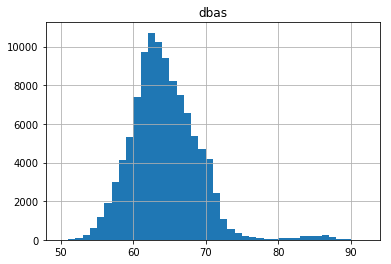

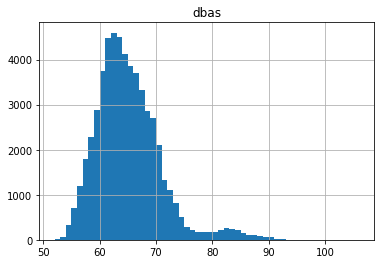

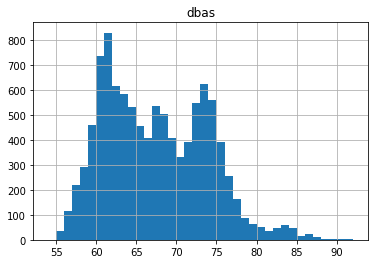

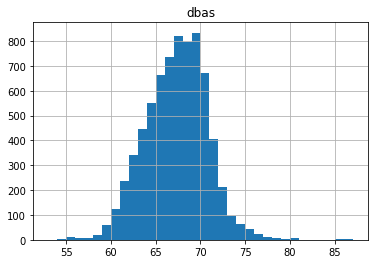

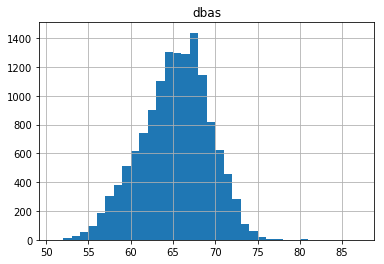

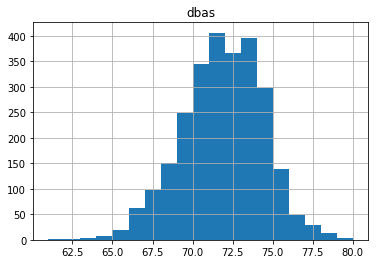

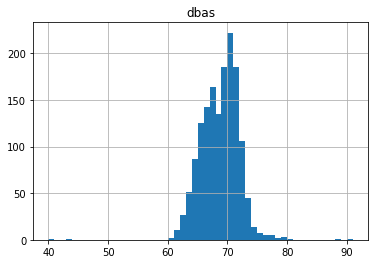

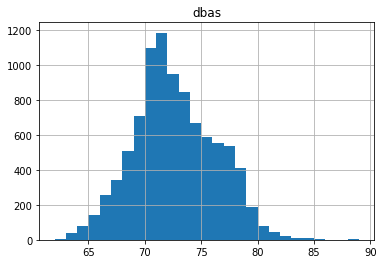

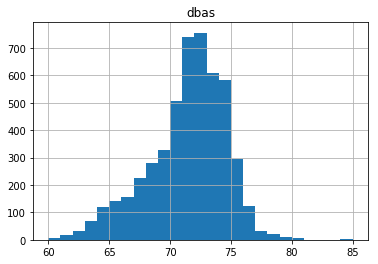

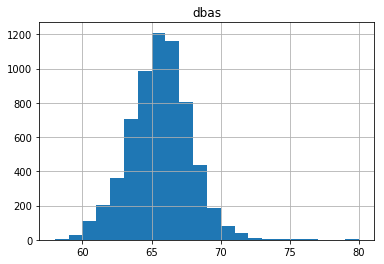

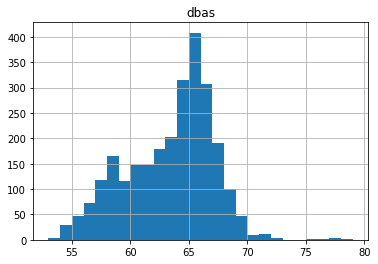

In [118]:
for location in distributions:
    
    print('Location ', location, ' distribution: ')
    currentDF = pd.DataFrame()
    
    for sensorID in distributions[location]:
        
        currentDF = currentDF.append(distributions[location][sensorID])
        min_dbas = currentDF['dbas'].min()
        max_dbas = currentDF['dbas'].max()
        nbins = max_dbas - min_dbas
        
    plot = currentDF.hist(bins=nbins)
    print(currentDF.describe())
    print('-----------------------------------------')

## Helper Functions

In [ ]:
def spatialJoin(sensorLat, sensorLon, sensorID, geoDataFrame):
    
    d = 300 # meters
    n_points = 20
    angles = np.linspace(0, 360, n_points)
    center = shapely.geometry.Point(sensorLon, sensorLat)
    polygon = Polygon(geog.propagate(center, angles, d))
    
    sinpoly = gpd.GeoDataFrame(crs={'init': 'epsg:4326'})
    sinpoly = sinpoly.append({'geometry': polygon, 'sensorID':sensorID}, ignore_index=True) 
    sinpoly = sinpoly.to_crs({'init':'epsg:3857'})
    
    dataframe = gpd.tools.sjoin(geoDataFrame, sinpoly, how='inner', op="within")
        
    return dataframe